In [1]:
%history -g -f "history.py"

In [1]:
import torch
import numpy as np
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from DatasetCreator import HAVSDataset

from CAE import *
from training_functions import *

In [2]:
BATCH_SIZE = 128
NUM_EPOCHS = 25

In [3]:
# Extracting the training, validation and testing data
compressed_file_path = "C:/Users/nyasha/Desktop/Masters-Nyasha/Processed Data/processed_data.npz"
x_train, x_test, x_val, y_train, y_test, y_val = get_train_test_data(compressed_file_path)

In [4]:
# Check if files have been imported correctly
print(x_train.shape)  
print(x_test.shape)
print(x_val.shape)
print(y_train.shape) 
print(y_test.shape)
print(y_val.shape)

(11035, 128, 44)
(3679, 128, 44)
(3679, 128, 44)
(11035,)
(3679,)
(3679,)


In [5]:
# Check if type is correct
print(type(x_train))  
print(type(x_test))
print(type(x_val))
print(type(y_train)) 
print(type(y_test))
print(type(y_val))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [6]:
# Define the transforms
transform = transforms.Compose(
    [
     transforms.ToTensor()
    ])

In [7]:
# Create the datasets
train_dataset = HAVSDataset(x_train, y_train, transform=transform)
val_dataset = HAVSDataset(x_val, y_val, transform=transform)
test_dataset = HAVSDataset(x_test, y_test, transform=transform)

In [8]:
# Creating the data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
class Encoder_3(nn.Module):
    def __init__(self):
        super(Encoder_3, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 8, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(8, 8, 3, stride=1, padding=1)
        
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.pool2 = nn.MaxPool2d(2, stride=2)    
        
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(8)
        self.bn3 = nn.BatchNorm2d(8)

    def forward(self, img):
        x = self.conv1(img)
        x = self.bn1(x)
        x = F.elu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.elu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.elu(x)        
        
        return x

class Decoder_3(nn.Module):
    def __init__(self):
        super(Decoder_3, self).__init__()
        
        self.deconv3 = nn.ConvTranspose2d(8, 8, 3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(8, 16, 3, stride=1, padding=1)
        self.deconv1 = nn.ConvTranspose2d(16, 1, 3, stride=1, padding=1)
        
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.bn3 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        
    def forward(self, encode):

        x = self.deconv3(encode)
        x = self.bn3(x)
        x = F.elu(x)
        
        x = self.upsample2(x)
        
        x = self.deconv2(x)
        x = self.bn2(x)
        x = F.elu(x)
        
        x = self.upsample1(x)
        
        x = self.deconv1(x)
        x = torch.sigmoid(x)
        
        return x
        
class CAE_3(nn.Module):
    def __init__(self):
        super(CAE_3, self).__init__()
        
        self.encoder = Encoder_3()
        self.decoder = Decoder_3()
        
    def forward(self, img):
        x = self.encoder(img)
        x = self.decoder(x)
        
        return x

In [10]:
# Select a model from ../Models
model_1  = CAE_3()

In [ ]:
model_1.encoder.

In [11]:
# Get number of parameters
pytorch_total_params_model_1 = sum(p.numel() for p in model_1.parameters())
print(f"The number of  parameters in this model is {pytorch_total_params_model_1}")

The number of  parameters in this model is 3913


In [12]:
device = get_device() 
model_on_device = model_1.to(device) # Move model to the current device

Running on the GPU


In [13]:
# Specify loss function
criterion = nn.BCELoss()

# Specify optimizer
optimizer = torch.optim.SGD(model_on_device.parameters(), lr=0.001)

In [14]:
# Train the CAE reconstruction model
train_cae(3, train_loader, criterion, optimizer, device, model_on_device)


C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\torch\nn\functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
Epoch: 1 	Training Loss: 101.447350
Epoch: 2 	Training Loss: 93.161489
Epoch: 3 	Training Loss: 90.677770


Training CAE 3 for 20 epochs seems to be very good.

In this paper https://www.ni.tu-berlin.de/fileadmin/fg215/teaching/nnproject/cnn_pre_trainin_paper.pdf CAE are used to point the network in the right direction instead of freezing the weights. The training of CNN is highly dependant on the model initialisation (local minima). Therefore randomly initialised weights might not give the best results as it may be necessary to first find a point closer to the absolute minima.

Use Ray Tune for parameter tuning

In [15]:
torch.save(model_on_device, "model.pth")
# model_on_device = torch.load("model.pth")

Original Images


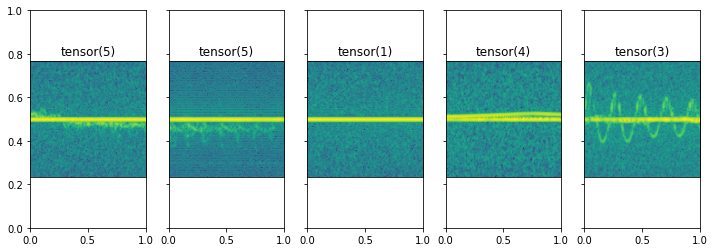

Reconstructed Images


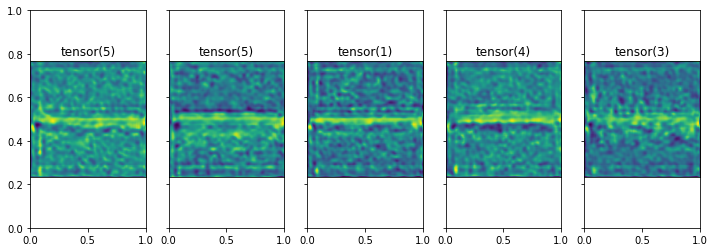

In [17]:
# Visualize CAE model performance,
model_on_device.eval()
with torch.no_grad():
    visualise_cae_performance(train_loader, device, model_on_device, 128, 128, 128)

In [356]:
# Freeze model weights
for param in model_on_device.parameters():
    param.requires_grad = True

In [357]:
class Flatten(nn.Module):
    """Flattening CNN output"""
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

In [358]:
# Remove transpose layer

dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device, dtype=torch.float)
net2 = nn.Sequential(*list(model_on_device.children())[:-1])
net2.eval() # Switch to evaluation mode
net2(images).shape
net2.add_module('flatten', Flatten())
dense_in = net2(images.cuda()).shape[1] # Get the dense layer shape


In [359]:
dense_in    

8192

In [360]:
# Replace the model's decoder with dense layer
model_on_device.decoder = nn.Sequential(
    Flatten(),
    nn.Linear(dense_in, 6),
    nn.ReLU(),
    nn.Softmax(dim=1)
)

A depth of 1 looks just fine

In [361]:
model_on_device = model_on_device.to(device)

In [363]:
class_weights = get_class_weights(y_train, device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_on_device.parameters(), lr=0.001)

In [138]:
 str({key:group[key] for group in (optimizer.param_groups) for key in sorted(group.keys()) if key != 'params'})

"{'dampening': 0, 'lr': 0.01, 'momentum': 0, 'nesterov': False, 'weight_decay': 0}"

In [ ]:
# Stick to SGD

In [364]:
# Train the classification model
train_model(150
, train_loader, val_loader, criterion, optimizer, device, model_on_device)

Epoch: 1/150 	 Training Loss: 2.5038, Accuracy: 23.63, Testing Loss: 1.7270, Accuracy: 26.39
Epoch: 2/150 	 Training Loss: 2.4620, Accuracy: 26.99, Testing Loss: 1.7177, Accuracy: 27.17
Epoch: 3/150 	 Training Loss: 2.4611, Accuracy: 27.30, Testing Loss: 1.8574, Accuracy: 13.28
Epoch: 4/150 	 Training Loss: 2.4525, Accuracy: 27.31, Testing Loss: 1.7274, Accuracy: 26.19
Epoch: 5/150 	 Training Loss: 2.4553, Accuracy: 27.53, Testing Loss: 1.7285, Accuracy: 26.28
Epoch: 6/150 	 Training Loss: 2.4527, Accuracy: 27.57, Testing Loss: 1.7262, Accuracy: 26.61
Epoch: 7/150 	 Training Loss: 2.4579, Accuracy: 27.48, Testing Loss: 1.7602, Accuracy: 24.09
Epoch: 8/150 	 Training Loss: 2.4358, Accuracy: 27.67, Testing Loss: 1.7142, Accuracy: 27.15
Epoch: 9/150 	 Training Loss: 2.4376, Accuracy: 27.72, Testing Loss: 1.8052, Accuracy: 17.73
Epoch: 10/150 	 Training Loss: 2.4411, Accuracy: 27.69, Testing Loss: 1.7024, Accuracy: 27.81
Epoch: 11/150 	 Training Loss: 2.4422, Accuracy: 27.73, Testing Loss:

KeyboardInterrupt: 

Consider applying early stopping
4 epochs on CAE_3 looks good

In [37]:
{key:group[key] for group in (optimizer.param_groups) for key in sorted(group.keys()) if key != 'params'}

{'betas': (0.9, 0.999), 'eps': 1e-08, 'lr': 0.01, 'weight_decay': 0}

In [39]:
optimizer.__class__.__name__

'Adamax'

In [162]:
# Evaluate model performance on test data
evaluate_model(test_loader, device, model_on_device, criterion)

Accuracy of the network on the test images: 53 %


(1.5040987588591495, 53.265524625267666)

It seems to be better to leave the dense layer as it is.
Increasing the number of filters seems to work.